# Movies Content Based Modelling

### Team A -  Sergi Abashidze, Camila Barbagallo, Paula García, Rocío González Lantero

#### 17/11/2020

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import sklearn.linear_model as lm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from xgboost import XGBRegressor 

In [2]:
data = pd.read_csv("OldMovies_complete.csv", low_memory=False)

In [3]:
data.head()

,imdbId,tmdbId,userId,movieId,rating,date_ratings,Action,Adventure,Animation,Children,...,Musical,Mystery,Romance,Sci.Fi,Thriller,War,Western,ReleaseDate,Duration,IMDB_Rating
0,100029,9399,599.0,26696,0.5,2017-06-26,1,0,0,0,...,0,0,0,0,0,0,0,1990,108,6.2
1,100029,9399,599.0,26696,0.5,2017-06-26,1,0,0,0,...,0,0,0,0,0,0,0,1990,108,6.2
2,100029,9399,599.0,26696,0.5,2017-06-26,1,0,0,0,...,0,0,0,0,0,0,0,1990,108,6.2
3,100029,9399,599.0,26696,0.5,2017-06-26,1,0,0,0,...,0,0,0,0,0,0,0,1990,108,6.2
4,100029,9399,599.0,26696,0.5,2017-06-26,1,0,0,0,...,0,0,0,0,0,0,0,1990,108,6.2


# 1. Data preparation

## 1.1 Data cleaning

### 1.1.1 Missing values

In [4]:
data.isna().sum()

imdbId          0
tmdbId          0
userId          0
movieId         0
rating          0
date_ratings    0
Action          0
Adventure       0
Animation       0
Children        0
Comedy          0
Crime           0
Documentary     0
Drama           0
Fantasy         0
Film.Noir       0
Horror          0
IMAX            0
Musical         0
Mystery         0
Romance         0
Sci.Fi          0
Thriller        0
War             0
Western         0
ReleaseDate     0
Duration        0
IMDB_Rating     0
dtype: int64

### 1.1.2 Duplicates

In [5]:
data.duplicated().sum()

9954016

In [6]:
df = data.drop_duplicates(inplace=False)

In [7]:
df.duplicated().sum()

0

## 1.2 Feature engineering

**Ids**

If we wanted to use the ids, we would need to preprocess them. However, we have enough information for each observation and little computing resources, so we will leave this for future work.

In [8]:
df.drop(['imdbId','tmdbId','movieId','userId'], axis=1, inplace=True)

C:\Users\Usuario\Anaconda3\envs\MachineLearning\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


__date_ratings__

To take the date into account within the models, we will extract the days since the rating and save the date as index.

In [9]:
# convert to date format: year-month-day
df.date_ratings = pd.to_datetime(df.date_ratings, format='%Y-%m-%d', errors='coerce')

#new column with todays date
df['today'] = '2020-11-17'

#convert new column to date
df.today = pd.to_datetime(df.today, format='%Y-%m-%d', errors='coerce')

#creating a new variable that describes for how many days a host has been a host
df['days_since_rating'] = (df['today']-df['date_ratings']).dt.days

#dropping today
df = df.drop('today', axis=1)

C:\Users\Usuario\Anaconda3\envs\MachineLearning\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\Usuario\Anaconda3\envs\MachineLearning\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Usuario\Anaconda3\envs\MachineLearning\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [10]:
#save date as index
df = df.set_index('date_ratings')

**ReleaseDate**

In [11]:
# convert to date format: year-
df.ReleaseDate = pd.to_datetime(df.ReleaseDate, format='%Y', errors='coerce')

#new column with todays date
df['year'] = '2020'

#convert new column to date
df.year = pd.to_datetime(df.year, format='%Y', errors='coerce')

#creating a new variable that describes for how many years the movie has been released
df['days_since_release'] = (df['year']-df['ReleaseDate']).dt.days

#dropping year and ReleaseDate, as we have already extracted the information they contain
df = df.drop(['year','ReleaseDate'], axis=1)

Once we have processed all the variables, the data looks like this:

In [12]:
df.head()

,rating,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Mystery,Romance,Sci.Fi,Thriller,War,Western,Duration,IMDB_Rating,days_since_rating,days_since_release
date_ratings,,,,,,,,,,,,,,,,,,,,,
2017-06-26,0.5,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,108,6.2,1240,10957
2000-11-23,4.0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,97,7.3,7299,10957
2005-05-31,1.0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,81,4.7,5649,10957
2007-02-18,3.0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,81,4.7,5021,10957
2017-06-26,2.0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,81,4.7,1240,10957


## 1.3  Train-test split

In [13]:
def train_test_ts(df, test_size= 0.2):
    size= int(np.round(len(df)*0.2))
    train= df.iloc[:-size]
    test= df.iloc[-size:]
    return train,test

In [14]:
y = df['rating']
X = df.drop('rating',axis=1)

We will use 70% of our data for training and 30% for testing.

In [15]:
X_train, X_test = train_test_ts(X, test_size=0.3)
y_train, y_test = train_test_ts(y, test_size=0.3)

## 1.4 Normalization

To start modelling giving the same importance to all our features we will normalize our data.

In [16]:
mm_scale = MinMaxScaler().fit(X_train)
X_train = mm_scale.transform(X_train)
X_test = mm_scale.transform(X_test)

# 2. Dimensionality reduction: PCA

We have a lot of features and we don't care about why a user prefers one movie to another, dimensionality reduction is recommended to simplify the modelling process and most likely give better results.

**Choose number of components**

In [17]:
pca = PCA().fit(X_train)
np.cumsum(pca.explained_variance_ratio_)

array([0.20050677, 0.36945844, 0.47399421, 0.55465005, 0.62182394,
       0.68013849, 0.72474107, 0.76734735, 0.80752021, 0.84342491,
       0.87553613, 0.90312808, 0.92607845, 0.94340969, 0.95777165,
       0.96990309, 0.97886803, 0.98490429, 0.99083805, 0.99372425,
       0.9964627 , 0.99843798, 1.        ])

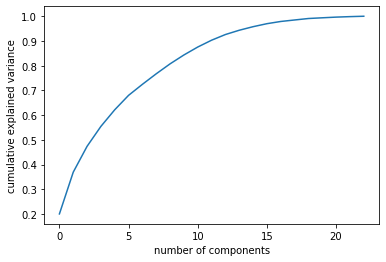

In [18]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

By looking at the table and graph, we conclude that after approximately the 19th principal component the explained variance doesn't increase significantly. Therefore, we will use 19 principal components. 

**Save number of components as features**

In [19]:
pca = PCA(n_components=19).fit(X_train)
X_train = pca.transform(X_train)
X_train = pd.DataFrame(data = X_train, 
                       columns = ['PC1', 'PC2','PC3','PC4','PC5','PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11','PC12'
                                  , 'PC13', 'PC14', 'PC15', 'PC16', 'PC17','PC18', 'PC19'])
X_test = pca.transform(X_test)
X_test = pd.DataFrame(data = X_test, 
                      columns = ['PC1', 'PC2','PC3','PC4','PC5','PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11','PC12'
                                , 'PC13', 'PC14', 'PC15', 'PC16', 'PC17','PC18', 'PC19'])

# 3. Modelling

## 3.1 Linear regression

In [20]:
mlr = lm.LinearRegression()
mlr.fit(X_train, y_train)

y_trainpred = mlr.predict(X_train)
y_pred = mlr.predict(X_test)

print ("Train Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_train, y_trainpred)))
print ("Test Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_test, y_pred)))

Train Root Mean Squared Error:  0.9412620050041913
Test Root Mean Squared Error:  0.9551073936369556


## 3.2 Decision tree

In [21]:
dtr = DecisionTreeRegressor(random_state=0)

dtr.fit(X_train,y_train)

y_trainpred = dtr.predict(X_train)
y_pred = dtr.predict(X_test)

print ("Train Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_train, y_trainpred)))
print ("Test Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_test, y_pred)))

Train Root Mean Squared Error:  0.10778419224119425
Test Root Mean Squared Error:  1.5543768312169308


## 3.3 Random forest

In [22]:
rf = RandomForestRegressor(random_state=0)

rf.fit(X_train,y_train)

y_trainpred = rf.predict(X_train)
y_pred = rf.predict(X_test)

print ("Train Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_train, y_trainpred)))
print ("Test Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_test, y_pred)))

Train Root Mean Squared Error:  0.4013595648172423
Test Root Mean Squared Error:  1.0109740563244067


## 3.4 MLP regressor

In [23]:
nn = MLPRegressor(random_state=0)

nn.fit(X_train, y_train)

y_trainpred = nn.predict(X_train)
y_pred = nn.predict(X_test)

print ("Train Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_train, y_trainpred)))
print ("Test Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_test, y_pred)))

Train Root Mean Squared Error:  0.9219168374330297
Test Root Mean Squared Error:  0.9590273334307909


## 3.5 Support vector regressor

In [24]:
svr = SVR()

svr.fit(X_train, y_train)

y_trainpred = svr.predict(X_train)
y_pred = svr.predict(X_test)

print ("Train Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_train, y_trainpred)))
print ("Test Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_test, y_pred)))

Train Root Mean Squared Error:  0.9330784196801502
Test Root Mean Squared Error:  0.9575314279298017


## 3.6 XGBoost

In [25]:
xgb = XGBRegressor()

xgb.fit(X_train, y_train)

y_trainpred = xgb.predict(X_train)
y_pred = xgb.predict(X_test)

print ("Train Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_train, y_trainpred)))
print ("Test Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_test, y_pred)))

Train Root Mean Squared Error:  0.8614380437815591
Test Root Mean Squared Error:  0.9799647626838621


## 3.6 Preliminary results

From the models above we have the following results:

| Model                 | Train  | Test   | Difference| Behaviour  |
|-----------------------|--------|--------|-----------|------------|
| **Linear Regression** | 0.9412 | 0.9551 | 0.0139    | Overfitted |
| **Decision Tree**     | 0.1078 | 1.5544 | 1.4466    | Overfitted |
| **Random Forest**     | 0.4014 | 1.011  | 0.6096    | Overfitted |
| <code style="background:yellow">**MLP Regressor**     | 0.9219 | 0.9590 | 0.0371    | Overfitted |
| **SVR**               | 0.9331 | 0.9575 | 0.0244    | Overfitted |
| <code style="background:yellow">**XGBoost**           | 0.8614 | 0.98   | 0.0546    | Overfitted |

We will proceed to fine tune MLP Regressor and XGBoost, as they seem to be the models that best predict the ratings for the movies.

# 4. Model fine tuning

Once we have the top models, we need to proceed to fine tune them, to get better results.

##  4.1 MLP Regressor

In [26]:
print('Parameters currently in use:\n')
nn.get_params()

Parameters currently in use:



{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 0,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [27]:
parameters = {
'hidden_layer_sizes': (np.arange(10,30,5), np.arange(10,30,5)),
'activation': ['identity','logistic','tanh','relu'],
'solver': ['adam','lbfgs','sgd'],
'learning_rate': ['invscaling','constant','adaptive']}


nn_rs = RandomizedSearchCV(estimator=nn, param_distributions=parameters, scoring='neg_root_mean_squared_error',
                            cv=10, verbose=2, random_state=42, n_jobs=-1)

In [28]:
nn_rs.fit(X_train, y_train)

y_trainpred = nn_rs.predict(X_train)
y_pred = nn_rs.predict(X_test)

print ("Train Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_train, y_trainpred)))
print ("Test Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_test, y_pred)))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.4min finished


Train Root Mean Squared Error:  0.9379164195501649
Test Root Mean Squared Error:  0.9490516506590705


In [29]:
print("Best Hyper Parameters:\n",nn_rs.best_params_)

Best Hyper Parameters:
 {'solver': 'adam', 'learning_rate': 'invscaling', 'hidden_layer_sizes': array([10, 15, 20, 25]), 'activation': 'logistic'}


## 4.2 XGBoost

In [30]:
print('Parameters currently in use:\n')
xgb.get_params()

Parameters currently in use:



{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [31]:
parameters = {
'max_depth': np.arange(10,30,5),
'min_child_weight': range(10,30),
'n_estimators': range(40, 100, 5),
'reg_alpha': [0.1,0.3,0.4,0.5],
'reg_lambda':[1.3,1.4,1.5,1.6,1.7],
'learning_rate': [0.3,0.2,0.25,0.1]}


xgb_rs = RandomizedSearchCV(estimator=xgb, param_distributions=parameters, scoring='neg_root_mean_squared_error',
                            cv=10, verbose=2, random_state=42, n_jobs=-1)

In [32]:
xgb_rs.fit(X_train, y_train)

y_trainpred = xgb_rs.predict(X_train)
y_pred = xgb_rs.predict(X_test)

print ("Train Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_train, y_trainpred)))
print ("Test Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_test, y_pred)))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 20.3min finished


Train Root Mean Squared Error:  0.8580082943697498
Test Root Mean Squared Error:  0.9741318111808973


In [35]:
print("Best Hyper Parameters:\n",xgb_rs.best_params_)

Best Hyper Parameters:
 {'reg_lambda': 1.6, 'reg_alpha': 0.1, 'n_estimators': 45, 'min_child_weight': 21, 'max_depth': 10, 'learning_rate': 0.1}


## 4.3 Final results

From the fine tuning performed above we have the following results:

| Model             | Train  | Test   | Difference | Behaviour           |
|-------------------|--------|--------|------------|---------------------|
| <code style="background:yellow">**MLP Regressor** | 0.9379 | 0.9491 | 0.0112     | Slightly Overfitted |
| **XGBoost**       | 0.858  | 0.9741 | 0.1161     | Overfitted          |
    
Therefore, we will consider the MLP regressor as our final model, because it has the best results among all the models runned thoughout the notebook. 

# 5. Final model

In [34]:
final_model = MLPRegressor(random_state=0)
final_model.set_params(**nn_rs.best_params_)

final_model.fit(X_train, y_train)

y_trainpred = final_model.predict(X_train)
y_pred = final_model.predict(X_test)

print ("Train Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_train, y_trainpred)))
print ("Test Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_test, y_pred)))

Train Root Mean Squared Error:  0.9379164195501649
Test Root Mean Squared Error:  0.9490516506590705


As explained throught the notebook, we have not been able to feed the model with all the information we wanted to, due to time constraint. Therefore, we expect that if we had been able to implement the NLP techniques needed, the scoring of the model would be much better. However, please note that the overfitting of the model is nearly 0, which is what we were seeking for: the generability of the model is high.